# A classifier for DES Y6 objects

In this notebook I train and test different classifers that can effectively separate LSBGs from artifacts in the DES Y6 data.

In [75]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
from astropy.io import fits


# ==== Scikit-learn =======================
# Preprocessing
from sklearn.preprocessing import StandardScaler #Standar scaler for standardization
from sklearn.model_selection import train_test_split # For random split

# Classifiers
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# ==========================================
# Matplotlib, urlib etc 
import urllib
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from PIL import Image
%matplotlib inline
# =========================================
# =========================================
# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    #plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return
plot_pretty()

**Helper functions**

Write a function that creates and plots 100 cutouts of objects , given their coordinates

In [33]:
def cutout_plot(ra_arr,dec_arr,numb,save=True):
    """
    This function gets the coordinates (ra,dec) of 
    a number of objects and outputs a figure with 100 cutouts
    
    Inputs:
    ra_arr - 1D array of RAs
    dec_arr - 1D array of DECs
    numb - where to start from creating the cutouts
    if 0, gives you the first 100 objects; if 100 gives you the next 100 etc
    save - whether to save the image or not, defualt = True
    """
    # Initialize array
    Array = np.zeros([100,64,64,3])
    
    zoom=15
    
    # Populate array
    for i in range(100):
        j = i + numb
        # Give a name to the figure. Name them as "Image_cand_(i).jpb
        # Where i is the number of the candidate
        # This is easy to change to ra, dec or coadd ID or whatever...
        fig_name = "Image_cand.jpg"
    
        #Create now the name of the URL
        # This need to have as inputs (that change) the RA, DEC of each objec and zoom
        RA_loc = ra_arr[j] #The RA of the i-th object
        DEC_loc = dec_arr[j] # The DEC of the i-th object
    
        url_name = "http://legacysurvey.org//viewer/jpeg-cutout?ra={0}&dec={1}&zoom={2}&layer=des-dr1".format(RA_loc,DEC_loc,zoom)
        #url_name = "https://www.legacysurvey.org//viewer/jpeg-cutout?ra={0}&dec={1}&layer=hsc2&zoom={2}".format(RA_loc,DEC_loc,zoom)
        urllib.request.urlretrieve(url_name, fig_name) #Retrieves and saves each image
    
        image = Image.open('Image_cand.jpg')
        # resize image
        new_image = image.resize((64, 64))
        # Convert the image to an RGB array
        im_array = np.asarray(new_image)
    
        Array[i] = im_array
    
        clear_output(wait=True)
        print('runs:',i)
    
    # ==========================================
    # Plot the cutouts generated in an array
    n_rows = 20
    n_cols = 5
    
    plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

    for i in range(n_rows*n_cols):
        #if (i==3):
        #    plt.title("Matched objects",fontsize=25)
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(Array[i]/255.)
        plt.axis('off')
    
    if (save==True):
        plt.savefig("Examples.pdf")

### Y6 Catalog around Fornax (or other area)

Here, we first import the full DES Y6 skim catalog, then we write a function that selects a region around a given coordinate (e.g. 1 degree around the center of Fornax) and create a feature matrix that can be subsequently used to perform classification.

In [49]:
DES_Y6 = fits.open('y6_gold_2_0_lsb_skim.fits')

In [68]:
# Import full catalog with all the properties
data = DES_Y6[1].data[:]

# Import RA and DEC coordinates
ra = data['RA']
dec = data['DEC']

In [72]:
def feat_mat_around(ra_c,dec_c,degs=1.):
    """
    Function that returns arrays of coordinates 
    and a feature matrix to be used for classification,
    around given coordinates.
    -------------------------
    Input:
    ra_c - central coordinate/RA
    dec_c - central coordinate/DEC
    degs - how many degrees around the center to keep/default=1
    -------------------------
    Output:
    ras_in - coordinates of objects that pass the criteria/RA
    decs_in - coordinates of objects that pass the criteria/DECs
    X_feat - feature matrix (unnormalized) of the objects that pass the criteria
    """
    
    # Define box of coordinates
    box = (ra>(ra_c-degs))&(ra<(ra_c+degs))&(dec>(dec_c-degs))&(dec<(dec_c+degs))
    
    # Keep only coordinates & features within the above coordinate box
    ras_in = ra[box]
    decs_in = dec[box]
    data_in = data[box]
    
    
    # Get different properties
    A_IMAGE_in = data_in['A_IMAGE']
    B_IMAGE_in = data_in['B_IMAGE']
    MAG_AUTO_G_in = data_in['MAG_AUTO_G']
    FLUX_RADIUS_G_in = 0.263*data_in['FLUX_RADIUS_G']
    MU_EFF_MODEL_G_in = data_in['MU_EFF_MODEL_G']
    MU_MAX_G_in = data_in['MU_MAX_G']
    MU_MAX_MODEL_G_in = data_in['MU_MAX_MODEL_G']
    MU_MEAN_MODEL_G_in = data_in['MU_MEAN_MODEL_G']
    MAG_AUTO_R_in = data_in['MAG_AUTO_R']
    FLUX_RADIUS_R_in = 0.263*data_in['FLUX_RADIUS_R']
    MU_EFF_MODEL_R_in = data_in['MU_EFF_MODEL_R']
    MU_MAX_R_in = data_in['MU_MAX_R']
    MU_MAX_MODEL_R_in = data_in['MU_MAX_MODEL_R']
    MU_MEAN_MODEL_R_in = data_in['MU_MEAN_MODEL_R']
    MAG_AUTO_I_in = data_in['MAG_AUTO_I']
    FLUX_RADIUS_I_in = 0.263*data_in['FLUX_RADIUS_I']
    MU_EFF_MODEL_I_in = data_in['MU_EFF_MODEL_I']
    MU_MAX_I_in = data_in['MU_MAX_I']
    MU_MAX_MODEL_I_in = data_in['MU_MAX_MODEL_I']
    MU_MEAN_MODEL_I_in = data_in['MU_MEAN_MODEL_I']
    
    # =========== Create extra features ============
    # Ellipticity
    Ell_in = 1. - B_IMAGE_in/A_IMAGE_in
    
    # Colors
    col_g_r_in = MAG_AUTO_G_in - MAG_AUTO_R_in
    col_g_i_in = MAG_AUTO_G_in - MAG_AUTO_I_in
    col_r_i_in = MAG_AUTO_R_in - MAG_AUTO_I_in

    # ==============================================
    # ==============================================
    # ========= Create the feature matrix ==========
    
    # Length of matrix
    len_n = len(ras_in)
    
    # Initialize
    X_mat_in = np.zeros([len_n,24])
    
    # Populate
    X_mat_in[:,0] = Ell_in
    X_mat_in[:,1] = col_g_r_in;X_mat_in[:,2] = col_g_i_in;X_mat_in[:,3] = col_r_i_in
    X_mat_in[:,4] = A_IMAGE_in;X_mat_in[:,5] = B_IMAGE_in
    # G-band
    X_mat_in[:,6] = MAG_AUTO_G_in
    X_mat_in[:,7] = FLUX_RADIUS_G_in
    X_mat_in[:,8] = MU_MAX_G_in
    X_mat_in[:,9] = MU_MAX_MODEL_G_in
    X_mat_in[:,10] = MU_EFF_MODEL_G_in
    X_mat_in[:,11] = MU_MEAN_MODEL_G_in
    # R-band
    X_mat_in[:,12] = MAG_AUTO_R_in
    X_mat_in[:,13] = FLUX_RADIUS_R_in
    X_mat_in[:,14] = MU_MAX_R_in
    X_mat_in[:,15] = MU_MAX_MODEL_R_in
    X_mat_in[:,16] = MU_EFF_MODEL_R_in
    X_mat_in[:,17] = MU_MEAN_MODEL_R_in
    # I-band
    X_mat_in[:,18] = MAG_AUTO_I_in
    X_mat_in[:,19] = FLUX_RADIUS_I_in
    X_mat_in[:,20] = MU_MAX_I_in
    X_mat_in[:,21] = MU_MAX_MODEL_I_in
    X_mat_in[:,22] = MU_EFF_MODEL_I_in
    X_mat_in[:,23] = MU_MEAN_MODEL_I_in
    
    # ============================================
    # ============================================
    # Return coordinates and matrix
    return ras_in, decs_in, X_mat_in

Get coordinates and feature matrix in region of $\pm 1^o$ from the center of the Fornax cluster, that has coordinates:

\begin{equation}
RA = 54.6162,\,\, DEC = -35.4483
\end{equation}

In [74]:
# Coordinates of the center of Fornax
RA_f = 54.6162
DEC_f = -35.4483

# Get things
ras_fornax, decs_fornax, X_mat_fornax = feat_mat_around(RA_f,DEC_f,degs=1.)

print(len(ras_fornax))

2039


## Part I: Train on Y3, check on Y6

In this part we train the classifier on objects from the Y3 catalog, with the Y3 parameters (without cross-matching the two catalogs)

We check two different types of artifacts; randomly selected and those visually rejected (harder to classify)

In [6]:
# Load catalogs as dataframes
LSBG_Y3_df = pd.read_csv('random_LSBGs_all.csv') # LSBGs
Artifacts_1_df = pd.read_csv('random_negative_all_1.csv') #"Easy artifacts
Artifacts_2_df = pd.read_csv('random_negative_all_2.csv') #"Hard" artifacts

In [9]:
print(np.shape(LSBG_Y3))

(20000, 24)


Get matrices with numberical values of the features

In [24]:
Mat_LSBG = LSBG_Y3_df.iloc[:,4:].values
Mat_Art_1 = Artifacts_1_df.iloc[:,4:].values
Mat_Art_2 = Artifacts_2_df.iloc[:,4:].values
print(np.shape(Mat_LSBG))

(20000, 20)


Get the **coordinates** of the objects - we will need that for visual inspection

In [30]:
# LSBGs
ra_LSBG = LSBG_Y3_df['ra'].values
dec_LSBG = LSBG_Y3_df['dec'].values

# Artifacts 1
ra_Art_1 = Artifacts_1_df['ra'].values
dec_Art_1 = Artifacts_1_df['dec'].values

# Artifacts 2 
ra_Art_2 = Artifacts_2_df['ra'].values
dec_Art_2 = Artifacts_2_df['dec'].values

**Feature Engineering**

Perform Feature engineering.

Define ellipticity and colors (at first)
Then we can add extra features, or check if some of them are reduntant

In [35]:
# ==================== For LSBGs ============================
# Ellipticity
Ell_LSBG = 1 - LSBG_Y3_df['B_IMAGE'].values/LSBG_Y3_df['A_IMAGE'].values

# Colors 
col_g_r_LSBG = LSBG_Y3_df['mag_auto_g'].values - LSBG_Y3_df['mag_auto_r'].values
col_g_i_LSBG = LSBG_Y3_df['mag_auto_g'].values - LSBG_Y3_df['mag_auto_i'].values
col_r_i_LSBG = LSBG_Y3_df['mag_auto_r'].values - LSBG_Y3_df['mag_auto_i'].values

# ==================== For Artifacts of type 1 ==============
# Ellipticity
Ell_Art_1 = 1 - Artifacts_1_df['B_IMAGE'].values/Artifacts_1_df['A_IMAGE'].values

# Colors
col_g_r_Art_1 = Artifacts_1_df['mag_auto_g'].values - Artifacts_1_df['mag_auto_r'].values
col_g_i_Art_1 = Artifacts_1_df['mag_auto_g'].values - Artifacts_1_df['mag_auto_i'].values
col_r_i_Art_1 = Artifacts_1_df['mag_auto_r'].values - Artifacts_1_df['mag_auto_i'].values

# ==================== For Artifacts of type 2 ==============
# Ellipticity
Ell_Art_2 = 1 - Artifacts_2_df['B_IMAGE'].values/Artifacts_2_df['A_IMAGE'].values

# Colors
col_g_r_Art_2 = Artifacts_2_df['mag_auto_g'].values - Artifacts_2_df['mag_auto_r'].values
col_g_i_Art_2 = Artifacts_2_df['mag_auto_g'].values - Artifacts_2_df['mag_auto_i'].values
col_r_i_Art_2 = Artifacts_2_df['mag_auto_r'].values - Artifacts_2_df['mag_auto_i'].values

Integrate the new engineered features to the feature matrices of LSBGs and artifacts

In [48]:
# LSBGs 
X_LSBG = np.column_stack((Ell_LSBG,col_g_r_LSBG,col_g_i_LSBG,col_r_i_LSBG,Mat_LSBG))
# Artifacts 1
X_Art_1 = np.column_stack((Ell_Art_1,col_g_r_Art_1,col_g_i_Art_1,col_r_i_Art_1,Mat_Art_1))
# Artifacts 2
X_Art_2 = np.column_stack((Ell_Art_2,col_g_r_Art_2,col_g_i_Art_2,col_r_i_Art_2,Mat_Art_2))

# ============================
# Let's print shape to check that everything is ok!
print(np.shape(X_LSBG))

(20000, 24)


### Part Ia) Combination of LSBGs and Artifacts of type 2 

In this part, for training, we combine the Y3 LSBGs with the Artifacts of type 2 ("hard" artifacts)

In [80]:
X_feat = np.concatenate((X_LSBG,X_Art_2))

y_ones = np.ones(20000);y_zeros = np.zeros(20000)
y_lab = np.concatenate((y_ones,y_zeros))

print(np.shape(X_feat))

(40000, 24)


In [81]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feat)

In [82]:
# Train
svc_1 = SVC(C=1e4, kernel='rbf', gamma=0.012)
svc_1.fit(X_scaled, y_lab)

# Predict
y_pred_svc = svc_1.predict(X_scaled)
print(accuracy_score(y_test,y_pred_svc))

NameError: name 'y_test' is not defined

In [83]:
y_pred_svc = svc_1.predict(X_scaled)
print(accuracy_score(y_lab,y_pred_svc))

0.865725


**Predict on Fornax and plot examples**

In [98]:
RA_f = 55.0475
DEC_f = -18.5875
ras_fornax, decs_fornax, X_mat_fornax = feat_mat_around(RA_f,DEC_f,degs=1.)

print(len(ras_fornax))

X_fornax_scaled = scaler.fit_transform(X_mat_fornax)
y_pred_fornax = svc_1.predict(X_fornax_scaled)

1794


In [99]:
print(len(y_pred_fornax[y_pred_fornax==1]))

137


In [100]:
# Get LSBG coords

runs: 99


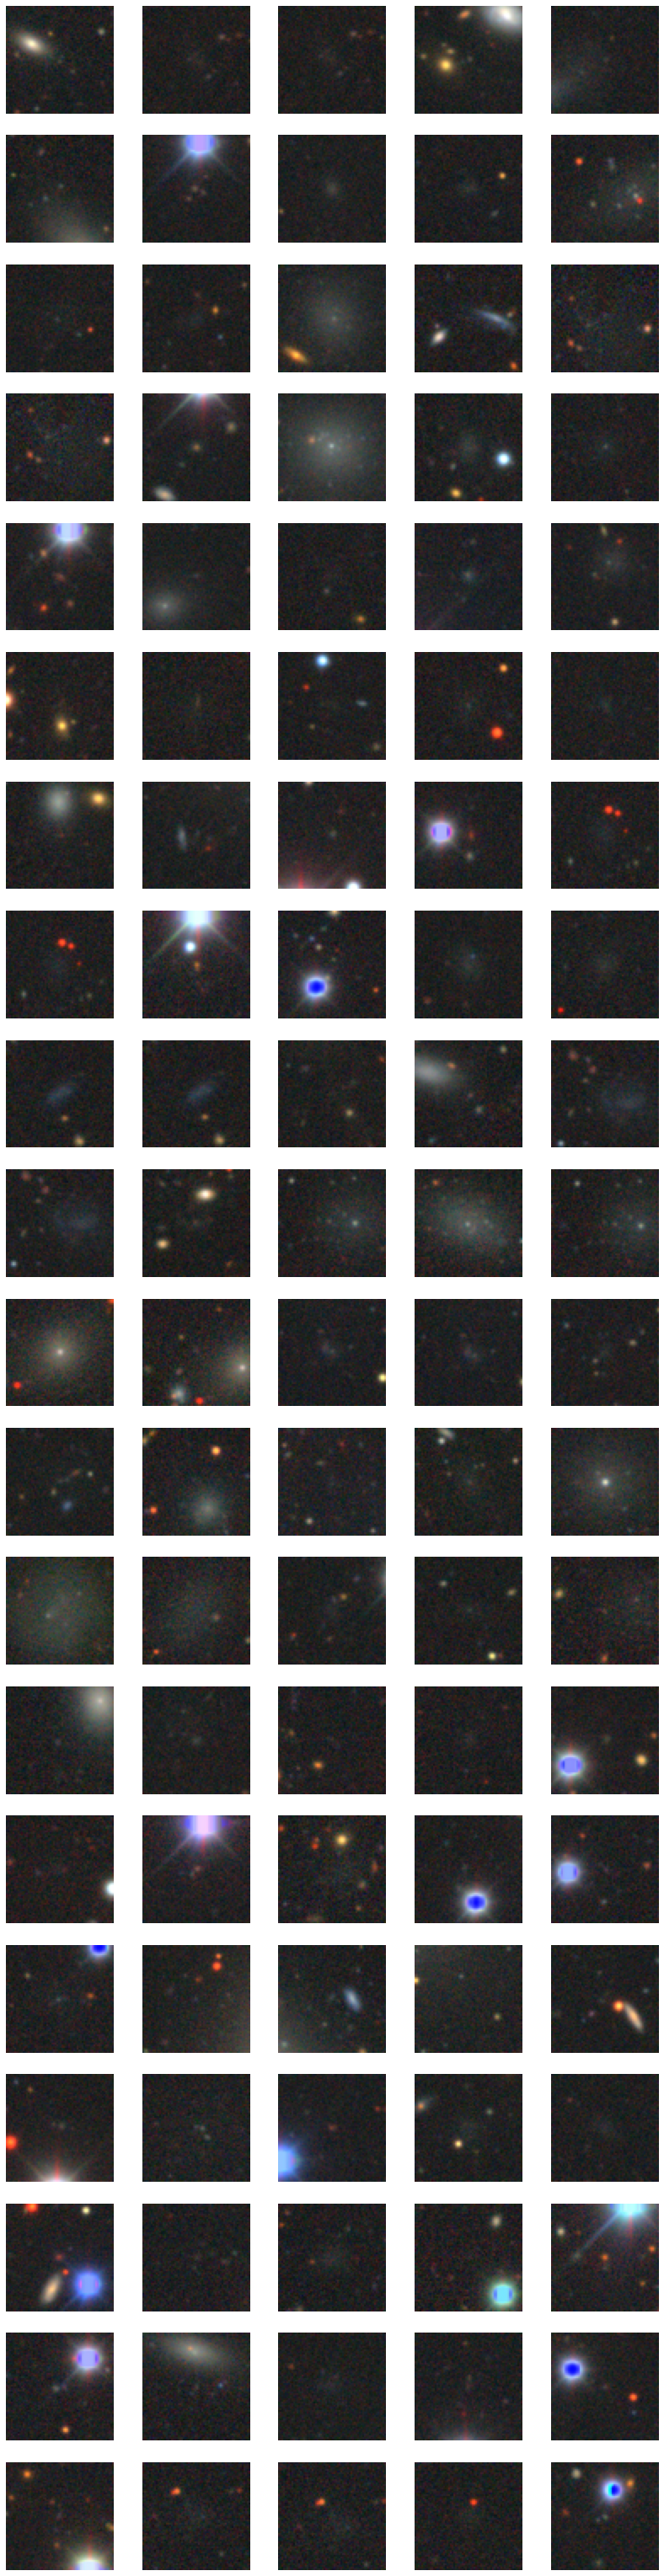

In [101]:
ra_pos = ras_fornax[y_pred_fornax==1]
dec_pos = decs_fornax[y_pred_fornax==1]

# Get plot
cutout_plot(ra_pos,dec_pos,0,save=True)